# Python implementation of Principal Components Analysis
This code was mostly produced by Sebastian Raschka. I can recommend his book Python Machine Learning. This book offers a hands-on approach to machine learning with nice code examples. <br>
In some places I expand the code and show the implementations for functions (e.g. covariance calculation). The sources are shown. <br>
<br>
Source of Raschka's original code: <br>
Source: http://sebastianraschka.com/Articles/2014_pca_step_by_step.html

#### Rationale of PCA.

"The main purposes of a principal component analysis... finding patterns to reduce the dimensions of the dataset with minimal loss of information."

"Here, our desired outcome of the principal component analysis is to project a feature space (our dataset consisting of n d-dimensional samples) onto a smaller subspace that represents our data “well”." 

#### Overview

PCA = linear transformation method. i.e. produce linear combinations of features. These combinations result in "components", and we seek to select the components that maximise variance in our dataset. i.e. reduce the number of features while maintaining most information.
PCA ignores class labels so we do not consider how good it is at predicting a specific class. By contrast, MDA (multi-discriminant analysis) considers the class labels.

As Raschka writes, "via PCA, we are projecting the entire set of data (without class labels) onto a different subspace, and in MDA, we are trying to determine a suitable subspace to distinguish between patterns that belong to different classes. Or, roughly speaking in PCA we are trying to find the axes with maximum variances where the data is most spread (within a class, since PCA treats the whole data set as one class), and in MDA we are additionally maximizing the spread between classes. ... In typical pattern recognition problems, a PCA is often followed by an MDA."

How do we know a component is good: "Later, we will compute eigenvectors (the components) from our data set and collect them in a so-called scatter-matrix (or alternatively calculate them from the covariance matrix). Each of those eigenvectors is associated with an eigenvalue, which tell us about the “length” or “magnitude” of the eigenvectors. If we observe that all the eigenvalues are of very similar magnitude, this is a good indicator that our data is already in a “good” subspace. Or if some of the eigenvalues are much much higher than others, we might be interested in keeping only those eigenvectors with the much larger eigenvalues, since they contain more information about our data distribution. "

#### Generate data (multivariate dataset). Generate 3 x variables (20 observations per variable)
#### Inputs: mean & covariance matrix (mu_vec1 & cov_mat1 respectively) (analagous to mean & variance)

In [1]:
import numpy as np
from numpy import linalg

### Show all output, not just the last part of each cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(23423) # random seed for consistency

mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
"""
multivariate_normal: Draw random samples from a multivariate normal distribution.
    The multivariate normal, multinormal or Gaussian distribution is a
    generalization of the one-dimensional normal distribution to higher
    dimensions.  Such a distribution is specified by its mean and
    covariance matrix.  These parameters are analogous to the mean
    (average or "center") and variance (standard deviation, or "width,"
    squared) of the one-dimensional normal distribution.
    arguments: (mean, cov[, size])
"""

assert class1_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

"""
assert: Optional message that appears if assert is false: shown in "" at the end
"""

###### Create 2 x 20 datasets:
mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
assert class2_sample.shape == (3,20), "The matrix has not the dimensions 3x20"
class2_sample

array([[ 1.44916587, -0.26967255,  0.54526949,  0.74758639,  0.80947549,
         1.26639345,  1.35454763, -0.94423276,  3.27632435,  0.53238116,
         3.51433167,  1.10150088,  1.0376285 ,  0.89319475,  0.80694944,
         0.01613778,  1.18540059,  0.54275957,  1.85845596,  2.21014588],
       [ 0.49876549, -1.02109047,  0.1072602 ,  2.3771934 ,  0.71847025,
        -0.58577396, -0.44409296,  1.79254477, -0.13980842,  0.57904477,
         1.89943081,  0.10434477,  0.75745346,  1.47550419,  2.87720696,
         1.6280275 ,  1.32334357,  1.38591309,  0.80053257,  1.2061014 ],
       [ 2.24984409,  0.551304  ,  2.37479728,  1.37846725,  0.84158419,
         0.79283304,  2.3992907 ,  2.1907745 ,  2.60313967, -0.23384966,
         1.89926438, -0.06815442,  0.68692472,  4.06404217, -0.28110085,
        -0.16521324,  0.9695535 ,  0.64436295, -0.07982832,  1.80543914]])

#### Visualise the 2 x classes (each one has the same 3 variables)

Populating the interactive namespace from numpy and matplotlib


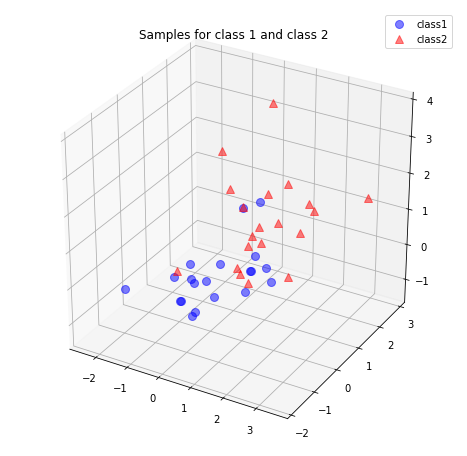

In [2]:
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

#### Concatenate all samples together (i.e. agnostic re class in PCA) (i.e. into a 3 x 40 matrix)

In [3]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
assert all_samples.shape == (3,40), "The matrix has not the dimensions 3x40"

#### Calculate mean of each variable: Put the means into a single vector (the vector has **d** dimensions)

In [4]:
mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

print('Mean Vector:\n', mean_vector)

Mean Vector:
 [[0.59630221]
 [0.47965616]
 [0.56413655]]


#### Just for curiousity, show the Standard Deviation of each variable

In [5]:
sd_x = np.std(all_samples[0,:])
sd_y = np.std(all_samples[1,:])
sd_z = np.std(all_samples[2,:])

sd_vector = np.array([[sd_x],[sd_y],[sd_z]])

print('SD Vector:\n', sd_vector)

SD Vector:
 [[1.17001318]
 [1.11972642]
 [1.16803876]]


### Create Scatter Matrix:  
### Result shape = ( d x d )
#### i.e. convert (3x40) into (3x3)
Matrix of 9 contains 5 unique values (4x2, + 1) <br>
Every time you dot multiply: (dx1).(1xd)  --- resulting in (d x d)

In [6]:
scatter_matrix = np.zeros((3,3))
for i in range(all_samples.shape[1]):
    scatter_matrix += (all_samples[:,i].reshape(3,1) - mean_vector).dot((all_samples[:,i].reshape(3,1) - mean_vector).T)
print('Scatter Matrix:\n', scatter_matrix)

Scatter Matrix:
 [[54.75723353  1.26043387 28.81217483]
 [ 1.26043387 50.1514903   6.1323721 ]
 [28.81217483  6.1323721  54.57258159]]


### Eigen-vectors in a scatter matrix
#### Values minus Means (twice, as the numerator). Transpose the second one to (1,variable_number). Then DOT multiply to get a 3,3 matrix.
compute eigenvectors (the components) from our data set and collect them in a so-called scatter-matrix (or alternatively calculate them from the covariance matrix). Each of those eigenvectors is associated with an eigenvalue, which tell us about the “length” or “magnitude” of the eigenvectors. If we observe that all the eigenvalues are of very similar magnitude, this is a good indicator that our data is already in a “good” subspace. Or if some of the eigenvalues are much much higher than others, we might be interested in keeping only those eigenvectors with the much larger eigenvalues, since they contain more information about our data distribution. Vice versa, eigenvalues that are close to 0 are less informative and we might consider in dropping those when we construct the new feature subspace.

** Dot product of two arrays. ** Specifically, <br>
If both a and b are 1-D arrays, it is inner product of vectors (without complex conjugation).  <br>
If both a and b are 2-D arrays, it is matrix multiplication, but using matmul or a @ b is preferred.  <br>
If either a or b is 0-D (scalar), it is equivalent to multiply and using numpy.multiply(a, b) or a * b is preferred. <b>

### Covariance matrix (alternative to scatter matrix)
Raschka used the function np.cov <br>
I show the source code for this function below (I name the function 'covariance' here). 
Source: https://github.com/numpy/numpy/blob/v1.8.0/numpy/lib/function_base.py#L1648 <br>
<br>
"The equations for the covariance matrix and scatter matrix are very similar, the only difference is, that we use the scaling factor 1 / (N−1) (here: 1 / (40−1) = 1 / 39) for the covariance matrix. Thus, their eigenspaces will be identical (identical eigenvectors, only the eigenvalues are scaled differently by a constant factor)."

#### Define the covariance matrix function

In [7]:
covariance_matrix = np.zeros((3,3))
for i in range(all_samples.shape[1]):
    covariance_matrix += (all_samples[:,i].reshape(3,1) - mean_vector).dot((all_samples[:,i].reshape(3,1) - mean_vector).T)
covariance_matrix =  covariance_matrix  /  (len(all_samples[0]) - 1)
print('Covariance Matrix:\n', covariance_matrix)

cov_mat = covariance_matrix

Covariance Matrix:
 [[1.40403163 0.03231882 0.73877371]
 [0.03231882 1.28593565 0.15724031]
 [0.73877371 0.15724031 1.39929696]]


In [8]:
len(all_samples[0])
len(all_samples[1])

40

40

#### Showing effect of 'conjugation'

In [9]:
class2_sample

array([[ 1.44916587, -0.26967255,  0.54526949,  0.74758639,  0.80947549,
         1.26639345,  1.35454763, -0.94423276,  3.27632435,  0.53238116,
         3.51433167,  1.10150088,  1.0376285 ,  0.89319475,  0.80694944,
         0.01613778,  1.18540059,  0.54275957,  1.85845596,  2.21014588],
       [ 0.49876549, -1.02109047,  0.1072602 ,  2.3771934 ,  0.71847025,
        -0.58577396, -0.44409296,  1.79254477, -0.13980842,  0.57904477,
         1.89943081,  0.10434477,  0.75745346,  1.47550419,  2.87720696,
         1.6280275 ,  1.32334357,  1.38591309,  0.80053257,  1.2061014 ],
       [ 2.24984409,  0.551304  ,  2.37479728,  1.37846725,  0.84158419,
         0.79283304,  2.3992907 ,  2.1907745 ,  2.60313967, -0.23384966,
         1.89926438, -0.06815442,  0.68692472,  4.06404217, -0.28110085,
        -0.16521324,  0.9695535 ,  0.64436295, -0.07982832,  1.80543914]])

In [10]:
x = class2_sample.conj()
x

array([[ 1.44916587, -0.26967255,  0.54526949,  0.74758639,  0.80947549,
         1.26639345,  1.35454763, -0.94423276,  3.27632435,  0.53238116,
         3.51433167,  1.10150088,  1.0376285 ,  0.89319475,  0.80694944,
         0.01613778,  1.18540059,  0.54275957,  1.85845596,  2.21014588],
       [ 0.49876549, -1.02109047,  0.1072602 ,  2.3771934 ,  0.71847025,
        -0.58577396, -0.44409296,  1.79254477, -0.13980842,  0.57904477,
         1.89943081,  0.10434477,  0.75745346,  1.47550419,  2.87720696,
         1.6280275 ,  1.32334357,  1.38591309,  0.80053257,  1.2061014 ],
       [ 2.24984409,  0.551304  ,  2.37479728,  1.37846725,  0.84158419,
         0.79283304,  2.3992907 ,  2.1907745 ,  2.60313967, -0.23384966,
         1.89926438, -0.06815442,  0.68692472,  4.06404217, -0.28110085,
        -0.16521324,  0.9695535 ,  0.64436295, -0.07982832,  1.80543914]])

Raschka used the function: **np.linalg.eig** <br>
I show the source code below for the sake of transparency. <br>
Source: https://github.com/numpy/numpy/blob/master/numpy/linalg/linalg.py

In [11]:
# Eigenvectors


def eig(a):
    """
    Compute the eigenvalues and right eigenvectors of a square array.
    Parameters
    ----------
    a : (..., M, M) array
        Matrices for which the eigenvalues and right eigenvectors will
        be computed
    Returns
    -------
    w : (..., M) array
        The eigenvalues, each repeated according to its multiplicity.
        The eigenvalues are not necessarily ordered. The resulting
        array will be of complex type, unless the imaginary part is
        zero in which case it will be cast to a real type. When `a`
        is real the resulting eigenvalues will be real (0 imaginary
        part) or occur in conjugate pairs
    v : (..., M, M) array
        The normalized (unit "length") eigenvectors, such that the
        column ``v[:,i]`` is the eigenvector corresponding to the
        eigenvalue ``w[i]``.
    Raises
    ------
    LinAlgError
        If the eigenvalue computation does not converge.
    See Also
    --------
    eigvals : eigenvalues of a non-symmetric array.
    eigh : eigenvalues and eigenvectors of a symmetric or Hermitian
           (conjugate symmetric) array.
    eigvalsh : eigenvalues of a symmetric or Hermitian (conjugate symmetric)
               array.
    Notes
    -----
    .. versionadded:: 1.8.0
    Broadcasting rules apply, see the `numpy.linalg` documentation for
    details.
    This is implemented using the _geev LAPACK routines which compute
    the eigenvalues and eigenvectors of general square arrays.
    The number `w` is an eigenvalue of `a` if there exists a vector
    `v` such that ``dot(a,v) = w * v``. Thus, the arrays `a`, `w`, and
    `v` satisfy the equations ``dot(a[:,:], v[:,i]) = w[i] * v[:,i]``
    for :math:`i \\in \\{0,...,M-1\\}`.
    The array `v` of eigenvectors may not be of maximum rank, that is, some
    of the columns may be linearly dependent, although round-off error may
    obscure that fact. If the eigenvalues are all different, then theoretically
    the eigenvectors are linearly independent. Likewise, the (complex-valued)
    matrix of eigenvectors `v` is unitary if the matrix `a` is normal, i.e.,
    if ``dot(a, a.H) = dot(a.H, a)``, where `a.H` denotes the conjugate
    transpose of `a`.
    Finally, it is emphasized that `v` consists of the *right* (as in
    right-hand side) eigenvectors of `a`.  A vector `y` satisfying
    ``dot(y.T, a) = z * y.T`` for some number `z` is called a *left*
    eigenvector of `a`, and, in general, the left and right eigenvectors
    of a matrix are not necessarily the (perhaps conjugate) transposes
    of each other.
    References
    ----------
    G. Strang, *Linear Algebra and Its Applications*, 2nd Ed., Orlando, FL,
    Academic Press, Inc., 1980, Various pp.
    Examples
    --------
    >>> from numpy import linalg as LA
    (Almost) trivial example with real e-values and e-vectors.
    >>> w, v = LA.eig(np.diag((1, 2, 3)))
    >>> w; v
    array([ 1.,  2.,  3.])
    array([[ 1.,  0.,  0.],
           [ 0.,  1.,  0.],
           [ 0.,  0.,  1.]])
    Real matrix possessing complex e-values and e-vectors; note that the
    e-values are complex conjugates of each other.
    >>> w, v = LA.eig(np.array([[1, -1], [1, 1]]))
    >>> w; v
    array([ 1. + 1.j,  1. - 1.j])
    array([[ 0.70710678+0.j        ,  0.70710678+0.j        ],
           [ 0.00000000-0.70710678j,  0.00000000+0.70710678j]])
    Complex-valued matrix with real e-values (but complex-valued e-vectors);
    note that a.conj().T = a, i.e., a is Hermitian.
    >>> a = np.array([[1, 1j], [-1j, 1]])
    >>> w, v = LA.eig(a)
    >>> w; v
    array([  2.00000000e+00+0.j,   5.98651912e-36+0.j]) # i.e., {2, 0}
    array([[ 0.00000000+0.70710678j,  0.70710678+0.j        ],
           [ 0.70710678+0.j        ,  0.00000000+0.70710678j]])
    Be careful about round-off error!
    >>> a = np.array([[1 + 1e-9, 0], [0, 1 - 1e-9]])
    >>> # Theor. e-values are 1 +/- 1e-9
    >>> w, v = LA.eig(a)
    >>> w; v
    array([ 1.,  1.])
    array([[ 1.,  0.],
           [ 0.,  1.]])
    """
    a, wrap = _makearray(a)
    _assertRankAtLeast2(a)
    _assertNdSquareness(a)
    _assertFinite(a)
    t, result_t = _commonType(a)

    extobj = get_linalg_error_extobj(
        _raise_linalgerror_eigenvalues_nonconvergence)
    signature = 'D->DD' if isComplexType(t) else 'd->DD'
    w, vt = _umath_linalg.eig(a, signature=signature, extobj=extobj)

    if not isComplexType(t) and all(w.imag == 0.0):
        w = w.real
        vt = vt.real
        result_t = _realType(result_t)
    else:
        result_t = _complexType(result_t)

    vt = vt.astype(result_t, copy=False)
    return w.astype(result_t, copy=False), wrap(vt)


def _makearray(a):
    new = asarray(a)
    wrap = getattr(a, "__array_prepare__", new.__array_wrap__)
    return new, wrap




## Calculate eigenvectors based on 'scatter_matrix'
#### "To show that the eigenvectors are indeed identical whether we derived them from the scatter or the covariance matrix, let us put an assert statement into the code." 
#### we will see that the eigenvalues were indeed scaled by the factor 39 when we derived it from the scatter matrix.

In [12]:
# eigenvectors and eigenvalues from the scatter matrix
eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)
            ### Compute the eigenvalues and right eigenvectors of a square array.
    
# eigenvectors and eigenvalues from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

print("Values, scatter matrix")
eig_val_sc
print("Vector, scatter matrix")
eig_vec_sc
print("Values, covariance matrix")
eig_val_cov 
print("Vector, covariance matrix")
eig_vec_cov

Values, scatter matrix


array([84.28102399, 25.36222228, 49.83805915])

Vector, scatter matrix


array([[-0.69361894, -0.68995971,  0.20699845],
       [-0.15212732, -0.14057467, -0.97831285],
       [-0.70409519,  0.71006645,  0.00745647]])

Values, covariance matrix


array([2.1610519 , 0.65031339, 1.27789895])

Vector, covariance matrix


array([[-0.69361894, -0.68995971,  0.20699845],
       [-0.15212732, -0.14057467, -0.97831285],
       [-0.70409519,  0.71006645,  0.00745647]])

In [13]:
# Eigenvectors are 3x3, and eigenvalues 1x3.
## Here we break up into 3 x separate eigenvectors & eigenvalues (i.e. per variable). & Print the results.
for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:,i].reshape(1,3).T
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    assert eigvec_sc.all() == eigvec_cov.all(), 'Eigenvectors are not identical'

    print('Eigenvector{}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {} from scatter matrix: {}'.format(i+1, eig_val_sc[i]))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print('Scaling factor: ', eig_val_sc[i]/eig_val_cov[i])
    print(40 * '-')

Eigenvector1: 
[[-0.69361894]
 [-0.15212732]
 [-0.70409519]]
Eigenvalue 1 from scatter matrix: 84.28102398595225
Eigenvalue 1 from covariance matrix: 2.1610518970756996
Scaling factor:  38.999999999999986
----------------------------------------
Eigenvector2: 
[[-0.68995971]
 [-0.14057467]
 [ 0.71006645]]
Eigenvalue 2 from scatter matrix: 25.362222282246467
Eigenvalue 2 from covariance matrix: 0.6503133918524733
Scaling factor:  39.000000000000014
----------------------------------------
Eigenvector3: 
[[ 0.20699845]
 [-0.97831285]
 [ 0.00745647]]
Eigenvalue 3 from scatter matrix: 49.83805915321693
Eigenvalue 3 from covariance matrix: 1.2778989526465878
Scaling factor:  39.00000000000001
----------------------------------------


### "Let us quickly check that the eigenvector-eigenvalue calculation is correct and satisfy the equation":
#### (Epsilon).(v) = (lambda).(v)
Σ=Covariancematrix <br>
v=Eigenvector <br>
λ=Eigenvalue

In [14]:
for i in range(len(eig_val_sc)):
    eigv = eig_vec_sc[:,i].reshape(1,3).T
    np.testing.assert_array_almost_equal(scatter_matrix.dot(eigv), eig_val_sc[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

### Visualizing the eigenvectors
And before we move on to the next step, just to satisfy our own curiosity, we plot the eigenvectors centered at the sample mean.

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['eig']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


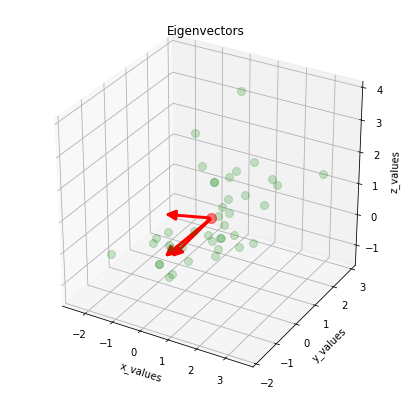

In [15]:
%pylab inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

Raschka used the function **np.linalg.norm** <br>
The source code is below <br>
Source: https://github.com/numpy/numpy/blob/master/numpy/linalg/linalg.py

In [16]:
def norm(x, ord=None, axis=None, keepdims=False):
    """
    Matrix or vector norm.
    This function is able to return one of eight different matrix norms,
    or one of an infinite number of vector norms (described below), depending
    on the value of the ``ord`` parameter.
    Parameters
    ----------
    x : array_like
        Input array.  If `axis` is None, `x` must be 1-D or 2-D.
    ord : {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
        Order of the norm (see table under ``Notes``). inf means numpy's
        `inf` object.
    axis : {int, 2-tuple of ints, None}, optional
        If `axis` is an integer, it specifies the axis of `x` along which to
        compute the vector norms.  If `axis` is a 2-tuple, it specifies the
        axes that hold 2-D matrices, and the matrix norms of these matrices
        are computed.  If `axis` is None then either a vector norm (when `x`
        is 1-D) or a matrix norm (when `x` is 2-D) is returned.
        .. versionadded:: 1.8.0
    keepdims : bool, optional
        If this is set to True, the axes which are normed over are left in the
        result as dimensions with size one.  With this option the result will
        broadcast correctly against the original `x`.
        .. versionadded:: 1.10.0
    Returns
    -------
    n : float or ndarray
        Norm of the matrix or vector(s).
    Notes
    -----
    For values of ``ord <= 0``, the result is, strictly speaking, not a
    mathematical 'norm', but it may still be useful for various numerical
    purposes.
    The following norms can be calculated:
    =====  ============================  ==========================
    ord    norm for matrices             norm for vectors
    =====  ============================  ==========================
    None   Frobenius norm                2-norm
    'fro'  Frobenius norm                --
    'nuc'  nuclear norm                  --
    inf    max(sum(abs(x), axis=1))      max(abs(x))
    -inf   min(sum(abs(x), axis=1))      min(abs(x))
    0      --                            sum(x != 0)
    1      max(sum(abs(x), axis=0))      as below
    -1     min(sum(abs(x), axis=0))      as below
    2      2-norm (largest sing. value)  as below
    -2     smallest singular value       as below
    other  --                            sum(abs(x)**ord)**(1./ord)
    =====  ============================  ==========================
    The Frobenius norm is given by [1]_:
        :math:`||A||_F = [\\sum_{i,j} abs(a_{i,j})^2]^{1/2}`
    The nuclear norm is the sum of the singular values.
    References
    ----------
    .. [1] G. H. Golub and C. F. Van Loan, *Matrix Computations*,
           Baltimore, MD, Johns Hopkins University Press, 1985, pg. 15
    Examples
    --------
    >>> from numpy import linalg as LA
    >>> a = np.arange(9) - 4
    >>> a
    array([-4, -3, -2, -1,  0,  1,  2,  3,  4])
    >>> b = a.reshape((3, 3))
    >>> b
    array([[-4, -3, -2],
           [-1,  0,  1],
           [ 2,  3,  4]])
    >>> LA.norm(a)
    7.745966692414834
    >>> LA.norm(b)
    7.745966692414834
    >>> LA.norm(b, 'fro')
    7.745966692414834
    >>> LA.norm(a, np.inf)
    4.0
    >>> LA.norm(b, np.inf)
    9.0
    >>> LA.norm(a, -np.inf)
    0.0
    >>> LA.norm(b, -np.inf)
    2.0
    >>> LA.norm(a, 1)
    20.0
    >>> LA.norm(b, 1)
    7.0
    >>> LA.norm(a, -1)
    -4.6566128774142013e-010
    >>> LA.norm(b, -1)
    6.0
    >>> LA.norm(a, 2)
    7.745966692414834
    >>> LA.norm(b, 2)
    7.3484692283495345
    >>> LA.norm(a, -2)
    nan
    >>> LA.norm(b, -2)
    1.8570331885190563e-016
    >>> LA.norm(a, 3)
    5.8480354764257312
    >>> LA.norm(a, -3)
    nan
    Using the `axis` argument to compute vector norms:
    >>> c = np.array([[ 1, 2, 3],
    ...               [-1, 1, 4]])
    >>> LA.norm(c, axis=0)
    array([ 1.41421356,  2.23606798,  5.        ])
    >>> LA.norm(c, axis=1)
    array([ 3.74165739,  4.24264069])
    >>> LA.norm(c, ord=1, axis=1)
    array([ 6.,  6.])
    Using the `axis` argument to compute matrix norms:
    >>> m = np.arange(8).reshape(2,2,2)
    >>> LA.norm(m, axis=(1,2))
    array([  3.74165739,  11.22497216])
    >>> LA.norm(m[0, :, :]), LA.norm(m[1, :, :])
    (3.7416573867739413, 11.224972160321824)
    """
    x = asarray(x)

    if not issubclass(x.dtype.type, (inexact, object_)):
        x = x.astype(float)

    # Immediately handle some default, simple, fast, and common cases.
    if axis is None:
        ndim = x.ndim
        if ((ord is None) or
            (ord in ('f', 'fro') and ndim == 2) or
            (ord == 2 and ndim == 1)):

            x = x.ravel(order='K')
            if isComplexType(x.dtype.type):
                sqnorm = dot(x.real, x.real) + dot(x.imag, x.imag)
            else:
                sqnorm = dot(x, x)
            ret = sqrt(sqnorm)
            if keepdims:
                ret = ret.reshape(ndim*[1])
            return ret

    # Normalize the `axis` argument to a tuple.
    nd = x.ndim
    if axis is None:
        axis = tuple(range(nd))
    elif not isinstance(axis, tuple):
        try:
            axis = int(axis)
        except Exception:
            raise TypeError("'axis' must be None, an integer or a tuple of integers")
        axis = (axis,)

    if len(axis) == 1:
        if ord == Inf:
            return abs(x).max(axis=axis, keepdims=keepdims)
        elif ord == -Inf:
            return abs(x).min(axis=axis, keepdims=keepdims)
        elif ord == 0:
            # Zero norm
            return (x != 0).astype(x.real.dtype).sum(axis=axis, keepdims=keepdims)
        elif ord == 1:
            # special case for speedup
            return add.reduce(abs(x), axis=axis, keepdims=keepdims)
        elif ord is None or ord == 2:
            # special case for speedup
            s = (x.conj() * x).real
            return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
        else:
            try:
                ord + 1
            except TypeError:
                raise ValueError("Invalid norm order for vectors.")
            absx = abs(x)
            absx **= ord
            ret = add.reduce(absx, axis=axis, keepdims=keepdims)
            ret **= (1 / ord)
            return ret
    elif len(axis) == 2:
        row_axis, col_axis = axis
        row_axis = normalize_axis_index(row_axis, nd)
        col_axis = normalize_axis_index(col_axis, nd)
        if row_axis == col_axis:
            raise ValueError('Duplicate axes given.')
        if ord == 2:
            ret =  _multi_svd_norm(x, row_axis, col_axis, amax)
        elif ord == -2:
            ret = _multi_svd_norm(x, row_axis, col_axis, amin)
        elif ord == 1:
            if col_axis > row_axis:
                col_axis -= 1
            ret = add.reduce(abs(x), axis=row_axis).max(axis=col_axis)
        elif ord == Inf:
            if row_axis > col_axis:
                row_axis -= 1
            ret = add.reduce(abs(x), axis=col_axis).max(axis=row_axis)
        elif ord == -1:
            if col_axis > row_axis:
                col_axis -= 1
            ret = add.reduce(abs(x), axis=row_axis).min(axis=col_axis)
        elif ord == -Inf:
            if row_axis > col_axis:
                row_axis -= 1
            ret = add.reduce(abs(x), axis=col_axis).min(axis=row_axis)
        elif ord in [None, 'fro', 'f']:
            ret = sqrt(add.reduce((x.conj() * x).real, axis=axis))
        elif ord == 'nuc':
            ret = _multi_svd_norm(x, row_axis, col_axis, sum)
        else:
            raise ValueError("Invalid norm order for matrices.")
        if keepdims:
            ret_shape = list(x.shape)
            ret_shape[axis[0]] = 1
            ret_shape[axis[1]] = 1
            ret = ret.reshape(ret_shape)
        return ret
    else:
        raise ValueError("Improper number of dimensions to norm.")

#### "The eigenvectors will form the axes of this new feature subspace. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which we can confirm by the following code:"

In [17]:
for ev in eig_vec_sc:
    numpy.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
    # instead of 'assert' because of rounding errors

### Sort the (eigenvalue, eigenvector) tuples from high to low: obviously just keep the ones with highest variance, i.e. highest "eigenvalue".

In [18]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]

eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

84.28102398595225
49.83805915321693
25.362222282246467


### "Choosing k eigenvectors with the largest eigenvalues"

####  "Combine the two eigenvectors with the highest eigenvalues to construct our d × k-dimensional eigenvector matrix 'W' "

In [19]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
            ### Stack arrays in sequence horizontally (column wise). 
            ### This is equivalent to concatenation along the second axis, except for 1-Darrays where it concatenates along the first axis. 
            ### Rebuilds arrays divided by `hsplit`.
print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.69361894  0.20699845]
 [-0.15212732 -0.97831285]
 [-0.70409519  0.00745647]]


### "Transforming the samples onto the new subspace"
#### "In the last step, we use the 2×3-dimensional matrix W that we just computed to transform our samples onto the new subspace via the equation y=(W^T).(x)"

In [20]:
transformed = matrix_w.T.dot(all_samples)
assert transformed.shape == (2,40), "The matrix is not 2x40 dimensional."

#### Visualise the transformed samples

(-4, 4)

(-4, 4)

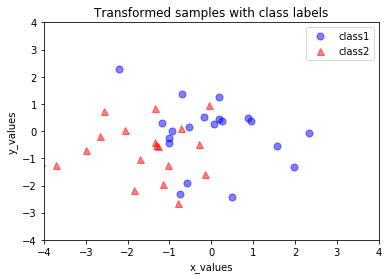

In [21]:
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()

# Using the PCA() class from the matplotlib.mlab library


### The in-built PCA() class from the matplotlib library

**Class attributes of PCA()**

Attrs:

    a : a centered unit sigma version of input a

    numrows, numcols: the dimensions of a

    mu : a numdims array of means of a

    sigma : a numdims array of atandard deviation of a

    fracs : the proportion of variance of each of the principal components

    Wt : the weight vector for projecting a numdims point or array into PCA space

    Y : a projected into PCA space

PC axes in terms of the measurement axes scaled by the standard deviations:
 [[-0.68744889 -0.18141962 -0.70320761]
 [ 0.21617507 -0.97552079  0.0403427 ]
 [ 0.6933126   0.12428241 -0.70983908]]


(-4, 4)

(-4, 4)

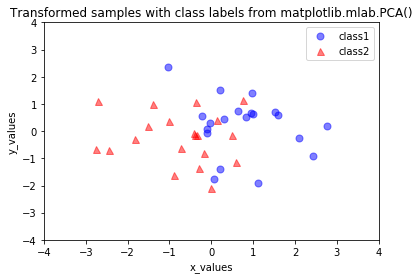

In [22]:
from matplotlib.mlab import PCA as mlabPCA

mlab_pca = mlabPCA(all_samples.T)

print('PC axes in terms of the measurement axes scaled by the standard deviations:\n', mlab_pca.Wt)

plt.plot(mlab_pca.Y[0:20,0],mlab_pca.Y[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(mlab_pca.Y[20:40,0], mlab_pca.Y[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend()
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

plt.show()

# Using the PCA() class from the sklearn.decomposition library


(-4, 4)

(-4, 4)

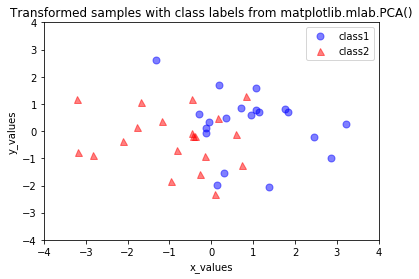

In [23]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(all_samples.T)

plt.plot(sklearn_transf[0:20,0],sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sklearn_transf[20:40,0], sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend()
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

plt.show()

(-4, 4)

(-4, 4)

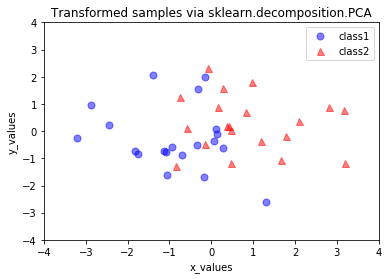

(-4, 4)

(-4, 4)

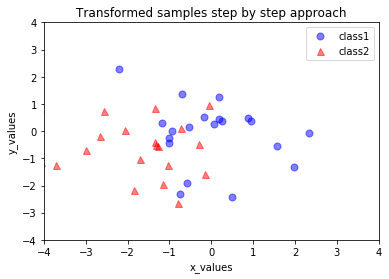

In [24]:
sklearn_transf = sklearn_transf * (-1)

# sklearn.decomposition.PCA
plt.plot(sklearn_transf[0:20,0],sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sklearn_transf[20:40,0], sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend()
plt.title('Transformed samples via sklearn.decomposition.PCA')
plt.show()

# step by step PCA
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples step by step approach')
plt.show()

#### Grandmother explanation of PCA

Imagine a big family dinner, where everybody starts asking you about PCA. First you explain it to your great-grandmother; then to you grandmother; then to your mother; then to your spouse; finally, to your daughter (who is a mathematician). Each time the next person is less of a layman. Here is how the conversation might go.

Great-grandmother: I heard you are studying "Pee-See-Ay". I wonder what that is...

You: Ah, it's just a method of summarizing some data. Look, we have some wine bottles standing here on the table. We can describe each wine by its colour, by how strong it is, by how old it is, and so on (see this very nice visualization of wine properties taken from here). We can compose a whole list of different characteristics of each wine in our cellar. But many of them will measure related properties and so will be redundant. If so, we should be able to summarize each wine with fewer characteristics! This is what PCA does.

Grandmother: This is interesting! So this PCA thing checks what characteristics are redundant and discards them?

You: Excellent question, granny! No, PCA is not selecting some characteristics and discarding the others. Instead, it constructs some new characteristics that turn out to summarize our list of wines well. Of course these new characteristics are constructed using the old ones; for example, a new characteristic might be computed as wine age minus wine acidity level or some other combination like that (we call them linear combinations).

In fact, PCA finds the best possible characteristics, the ones that summarize the list of wines as well as only possible (among all conceivable linear combinations). This is why it is so useful.

Mother: Hmmm, this certainly sounds good, but I am not sure I understand. What do you actually mean when you say that these new PCA characteristics "summarize" the list of wines?

You: I guess I can give two different answers to this question. First answer is that you are looking for some wine properties (characteristics) that strongly differ across wines. Indeed, imagine that you come up with a property that is the same for most of the wines. This would not be very useful, wouldn't it? Wines are very different, but your new property makes them all look the same! This would certainly be a bad summary. Instead, PCA looks for properties that show as much variation across wines as possible.

The second answer is that you look for the properties that would allow you to predict, or "reconstruct", the original wine characteristics. Again, imagine that you come up with a property that has no relation to the original characteristics; if you use only this new property, there is no way you could reconstruct the original ones! This, again, would be a bad summary. So PCA looks for properties that allow to reconstruct the original characteristics as well as possible.

Surprisingly, it turns out that these two aims are equivalent and so PCA can kill two birds with one stone.

Spouse: But darling, these two "goals" of PCA sound so different! Why would they be equivalent?

You: Hmmm. Perhaps I should make a little drawing (takes a napkin and starts scribbling). Let us pick two wine characteristics, perhaps wine darkness and alcohol content -- I don't know if they are correlated, but let's imagine that they are. Here is what a scatter plot of different wines could look like:

PCA exemplary data

Each dot in this "wine cloud" shows one particular wine. You see that the two properties (x and y on this figure) are correlated. A new property can be constructed by drawing a line through the center of this wine cloud and projecting all points onto this line. This new property will be given by a linear combination w1x+w2y, where each line corresponds to some particular values of w1 and w2.

Now look here very carefully -- here is how these projections look like for different lines (red dots are projections of the blue dots):

PCA animation: variance and reconstruction error

As I said before, PCA will find the "best" line according to two different criteria of what is the "best". First, the variation of values along this line should be maximal. Pay attention to how the "spread" (we call it "variance") of the red dots changes while the line rotates; can you see when it reaches maximum? Second, if we reconstruct the original two characteristics (position of a blue dot) from the new one (position of a red dot), the reconstruction error will be given by the length of the connecting red line. Observe how the length of these red lines changes while the line rotates; can you see when the total length reaches minimum?

If you stare at this animation for some time, you will notice that "the maximum variance" and "the minimum error" are reached at the same time, namely when the line points to the magenta ticks I marked on both sides of the wine cloud. This line corresponds to the new wine property that will be constructed by PCA.

By the way, PCA stands for "principal component analysis" and this new property is called "first principal component". And instead of saying "property" or "characteristic" we usually say "feature" or "variable".

Daughter: Very nice, papa! I think I can see why the two goals yield the same result: it is essentially because of the Pythagoras theorem, isn't it? Anyway, I heard that PCA is somehow related to eigenvectors and eigenvalues; where are they on this picture?

You: Brilliant observation. Mathematically, the spread of the red dots is measured as the average squared distance from the center of the wine cloud to each red dot; as you know, it is called the variance. On the other hand, the total reconstruction error is measured as the average squared length of the corresponding red lines. But as the angle between red lines and the black line is always 90∘, the sum of these two quantities is equal to the average squared distance between the center of the wine cloud and each blue dot; this is precisely Pythagoras theorem. Of course this average distance does not depend on the orientation of the black line, so the higher the variance the lower the error (because their sum is constant). This hand-wavy argument can be made precise (see here).

By the way, you can imagine that the black line is a solid rod and each red line is a spring. The energy of the spring is proportional to its squared length (this is known in physics as the Hooke's law), so the rod will orient itself such as to minimize the sum of these squared distances. I made a simulation of how it will look like, in the presence of some viscous friction:

PCA animation: pendulum

Regarding eigenvectors and eigenvalues. You know what a covariance matrix is; in my example it is a 2×2 matrix that is given by
(1.070.630.630.64).
What this means is that the variance of the x variable is 1.07, the variance of the y variable is 0.64, and the covariance between them is 0.63. As it is a square symmetric matrix, it can be diagonalized by choosing a new orthogonal coordinate system, given by its eigenvectors (incidentally, this is called spectral theorem); corresponding eigenvalues will then be located on the diagonal. In this new coordinate system, the covariance matrix is diagonal and looks like that:
(1.52000.19),
meaning that the correlation between points is now zero. It becomes clear that the variance of any projection will be given by a weighted average of the eigenvalues (I am only sketching the intuition here). Consequently, the maximum possible variance (1.52) will be achieved if we simply take the projection on the first coordinate axis. It follows that the direction of the first principal component is given by the first eigenvector of the covariance matrix. (More details here.)

You can see this on the rotating figure as well: there is a gray line there orthogonal to the black one; together they form a rotating coordinate frame. Try to notice when the blue dots become uncorrelated in this rotating frame. The answer, again, is that it happens precisely when the black line points at the magenta ticks. Now I can tell you how I found them: they mark the direction of the first eigenvector of the covariance matrix, which in this case is equal to (0.81,0.58).

#### Why PCA is useful

PCA is the simplest of the true eigenvector-based multivariate analyses. Often, its operation can be thought of as revealing the internal structure of the data in a way that best explains the variance in the data. If a multivariate dataset is visualised as a set of coordinates in a high-dimensional data space (1 axis per variable), PCA can supply the user with a lower-dimensional picture, a projection of this object when viewed from its most informative viewpoint. This is done by **using only the first few principal components so that the dimensionality of the transformed data is reduced.**



#### Eigenvector explanation

To understand why you encounter eigenvalues/eigenvectors everywhere, you must first understand why you encounter matrices and vectors everywhere.

In a vast number of situations, the objects you study and the stuff you can do with them relate to vectors and linear transformations, which are represented as matrices.

So, in many many interesting situations, important relations are expressed as
y⃗ =Mx⃗ 
where y⃗  and x⃗  are vectors and M is a matrix. This ranges from systems of linear equations you have to solve (which occurs virtually everywhere in science and engineering) to more sophisticated engineering problems (finite element simulations). It also is the foundation for (a lot of) quantum mechanics. It is further used to describe the typical geometric transformations you can do with vector graphics and 3D graphics in computer games.

Now, it is generally not straight forward to look at some matrix M and immediately tell what it is going to do when you multiply it with some vector x⃗ . Also, in the study of iterative algorithms you need to know something about higher powers of the matrix M, i.e. Mk=M⋅M⋅...M, k times. This is a bit awkward and costly to compute in a naive fashion.

For a lot of matrices, you can find special vectors with a very simple relationship between the vector x⃗  itself, and the vector y⃗ =Mx. For example, if you look at the 2x2 matrix (0110), you see that the vector (11) when multiplied with the matrix will just give you that vector again!

For such a vector, it is very easy to see what Mx⃗  looks like, and even what Mkx⃗  looks like, since, obviously, repeated application won't change it.

This observation is generalized by the concept of eigenvectors. An eigenvector of a matrix M is any vector x⃗  that only gets scaled (i.e. just multiplied by a number) when multiplied with M. Formally,
Mx⃗ =λx⃗ 
for some number λ (real or complex depending on the matrices you are looking at).

So, if your matrix M describes a system of some sort, the eigenvectors are those vectors that, when they go through the system, are changed in a very easy way. If M, for example, describes geometric operations, then M could, in principle, stretch and rotate your vectors. But eigenvectors only get stretched, not rotated.

Reference; https://math.stackexchange.com/questions/36815/a-simple-explanation-of-eigenvectors-and-eigenvalues-with-big-picture-ideas-of